In [1]:
import nibabel as nib
import numpy as np
import os
import glob
import sys
import SimpleITK as sitk
# !{sys.executable} -m pip install seaborn --user
abs_dir="/mnt/data/mranzini"
# abs_dir="/Users/Marta/Desktop/mountpoint"
sys.path.append(os.path.join(*[abs_dir, "Code", "Demic-v0.1"]))
import pandas as pd
from Demic.util.image_process import *
# from Demic.image_io.file_read_write import *

import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append("/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/basic_unet_monai/src")
from io_utils import search_file_in_folder_list

In [2]:
def compute_dice(seg1, seg2, label=1.0):
    # flatten the segmentations
    seg1 = seg1.flatten()
    seg2 = seg2.flatten()

    if len(seg1) != len(seg2):
        raise InputError('The two segmentations have different dimensions - not comparable!')

    yt = np.asarray(seg1 == label, np.float32)
    yp = np.asarray(seg2 == label, np.float32)
    
    intersection = np.multiply(yt, yp)
    union = np.asarray(yt + yp > 0, np.float32)
    dice = 2 * np.sum(intersection) / (np.sum(yt) + np.sum(yp) + 1e-10)
#     print(f"Mean 3D Dice = {dice}")
    
    return dice 

In [3]:
def percentage_dice_per_slice(seg1, seg2, dice_thr=0.9):
    """
    Computes the percentage of slices that have Dice score > dice_thr
    inputs
        - seg1: first segmentation mask, considered as ground truth
        - seg2: second segmentation mask to compare to first
        - label: which label to compute the dice score for
    output:
        - percentage: percentage of slices with dice above the threshold
    NOTE: it expects the slicing to happen along the first dimension (as read by SimpleITK)
    """
    nr_slices = np.shape(seg1)[0]
    all_slices_dice = np.empty(nr_slices)
    for i in range(0, nr_slices):
        temp_seg1 = seg1[i, ...]
        temp_seg2 = seg2[i, ...]
        
        # if the foreground segmentation is empty in the GT, compute the the Dice for the background
        if np.all(temp_seg1 == 0.0):
            all_slices_dice[i] = compute_dice(temp_seg1, temp_seg2, label=0.0)
        # else consider the dice of the foreground
        else:
            all_slices_dice[i] = compute_dice(temp_seg1, temp_seg2, label=1.0)
                
    # compute the percentage of slices with dice above the threshold
    nr_good_slices = np.count_nonzero(all_slices_dice >= dice_thr)
#     percentage = 100 *  nr_good_slices / nr_slices
    percentage = nr_good_slices / nr_slices
#     print(f"Nr slices >= {dice_thr}: {nr_good_slices}/{nr_slices} - {percentage}%")
    
    return percentage   

In [4]:
def load_nifty_volume_as_4d_array(filename):
    img_obj = sitk.ReadImage(filename)
    data_array = sitk.GetArrayFromImage(img_obj)
    spacing = img_obj.GetSpacing()
    direction = img_obj.GetDirection()
    shape = data_array.shape
    if(len(shape) == 4):
        data_array = np.moveaxis(data_array, 0, -1) 
    elif(len(shape) == 3):
        data_array = np.expand_dims(data_array, axis = -1)
    else:
        raise ValueError("unsupported image dim: {0:}".format(len(shape)))
    output = {}
    output['data_array'] = data_array
    output['spacing']    = (spacing[2], spacing[1], spacing[0])
    output['direction']  = direction
    return output

In [5]:
def read_nifti(nifti_file):
#     img_nii = nib.load(nifti_file)
#     img = img_nii.get_fdata()
    
    img_dict = load_nifty_volume_as_4d_array(nifti_file)
    img = img_dict['data_array']
    
    # if two channels, get the foreground one
    if img.shape[3] > 1:
        img = img[..., 1]
        
    return img

In [6]:
def apply_post_processing(input_pred, pred_thr=0.5):
    
    strt = ndimage.generate_binary_structure(3,2) # iterate structure
    input_pred = input_pred > pred_thr   # TODO: check that this step is actually needed - Guotai did not have but need to check what activation he had in final layer
    post_mask = ndimage.morphology.binary_closing(input_pred, strt)
    post_mask = get_largest_component(post_mask)
    postprocessed = np.asarray(post_mask*input_pred, np.uint8)

    return postprocessed

In [7]:
def read_and_compute_dice(label_file, prediction_file, metric=compute_dice, remove_outliers=False):
    label = np.squeeze(read_nifti(label_file))
    prediction = np.squeeze(read_nifti(prediction_file))
    if remove_outliers:
        prediction = apply_post_processing(prediction)
    prediction_bin = prediction > 0.5
    return metric(label, prediction_bin)

In [8]:
# set parameters:
guotai_retrained_root = ["/mnt/data/mranzini/Desktop/GIFT-Surg/Retraining_with_expanded_dataset/" +
                         "inference_on_validation/expanded"]
monai_inplanecrop_root = ["/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/basic_unet_monai/tests_deterministic_seeds" +
                      "/monai0.2.0_tests/2020-09-22_15-50-00_monai0.2.0-MONAI_unet-Batch_Dice_Xent_two_channel_inplanecrop" +
                       "/inf_on_valid_valid_key_metric=0.9504"]
monai_dynunet_root = ["/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/basic_unet_monai/tests_deterministic_seeds" +
                      "/monai0.3.0_tests/2020-10-08_09-47-58_monai0.3.0-MONAI_dynUNet_inplanespacing_continue" +
                       "/inf_on_valid_valid_key_metric=0.9458"]
monai_dynunet_batch_root = ["/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/basic_unet_monai/tests_deterministic_seeds" +
                      "/monai0.3.0_tests/2020-10-09_11-31-03_monai0.3.0-MONAI_dynUNet_batch_Dice" +
                       "/inf_on_valid_valid_key_metric=0.9481"]
monai_dynunet_val_perc = ["/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/basic_unet_monai/tests_deterministic_seeds" +
                          "/monai0.3.0_tests/2020-10-29_21-42-11_monai0.3.0-MONAI_dynUNet_Diceto2_valpercentage" +
                           "/inf_on_valid_valid_key_metric=0.92"]
nnUnet_uniform_root = ["/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/basic_unet_monai/tests_deterministic_seeds" +
                        "/nnUNet_comparison/nnUNet_UniformSampling_pred_val"]
is_validation_set = True

# list folders to search for the data
data_root = ["/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset/GroupA", 
             "/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset/GroupB1",
             "/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset/GroupB2", 
             "/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset_extension/GroupC",
             "/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset_extension/GroupD",
             "/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset_extension/GroupE",
             "/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset_extension/GroupF"]

# list of subject IDs to search for data
list_root = "/mnt/data/mranzini/Desktop/GIFT-Surg/Retraining_with_expanded_dataset/config/file_names"
if not is_validation_set:
    training_list = [os.path.join(list_root, "list_train_files.txt")]
else:
    training_list = [os.path.join(list_root, "list_validation_h_files.txt"),
                    os.path.join(list_root, "list_validation_p_files.txt")]

full_list_mean_dice = {"subj_id": [], "Group": [], 
                       "NeuroImage": [], "MONAI_inplanecrop":[], "MONAI_dynUnet": [], 
                       "MONAI_dynUnet_batch": [], "MONAI_dynUnet_val_perc": [], "nnUNet_uniform": []}
full_list_percentage_slice = {"subj_id": [], "Group": [], 
                               "NeuroImage": [], "MONAI_inplanecrop":[], "MONAI_dynUnet": [], 
                              "MONAI_dynUnet_batch": [], "MONAI_dynUnet_val_perc": [], "nnUNet_uniform": []}
for scan_list in training_list:
    with open(scan_list) as f:
        for line in f:
            subject = line.rstrip()
            print(subject)
            image_basename = "{}{}.nii.gz".format(subject, '_Image')
            image_filename = search_file_in_folder_list(data_root, image_basename)
            label_basename = "{}{}.nii.gz".format(subject, '_Label')
            label_filename = search_file_in_folder_list(data_root, label_basename)
            
            get_group = image_filename[image_filename.find("Group") + 5]
            if get_group == "B":
                get_group = image_filename[image_filename.find("Group") + 5] + \
                    image_filename[image_filename.find("Group") + 6]
                
            guotai_retrained_basename = os.path.join("Group{}".format(get_group), "{}_segment.nii.gz".format(subject))
            guotai_retrained_filename = search_file_in_folder_list(guotai_retrained_root, guotai_retrained_basename)
            
            monai_basename = os.path.join("{}_Image".format(subject), "{}_Image_seg.nii.gz".format(subject))
            monai_inplanecrop_filename =  search_file_in_folder_list(monai_inplanecrop_root, monai_basename)
            monai_dynunet_filename =  search_file_in_folder_list(monai_dynunet_root, monai_basename)
            monai_dynunet_batch_filename =  search_file_in_folder_list(monai_dynunet_batch_root, monai_basename)
            monai_dynunet_valperc_filename =  search_file_in_folder_list(monai_dynunet_val_perc, monai_basename)
            
            nnUnet_basename = "Group{}_{}_Image.nii.gz".format(get_group, subject)
            nnUnet_uniform_filename = search_file_in_folder_list(nnUnet_uniform_root, nnUnet_basename)
            
            if os.path.isfile(image_filename) and os.path.isfile(label_filename):
                full_list_mean_dice['subj_id'].append(subject)
                full_list_mean_dice['Group'].append(get_group)
                full_list_percentage_slice['subj_id'].append(subject)
                full_list_percentage_slice['Group'].append(get_group)
                # compute metrics between gt and seg - MONAI
                full_list_mean_dice['NeuroImage'].append(read_and_compute_dice(label_filename, 
                                                                                     guotai_retrained_filename,
                                                                                     metric=compute_dice))
                full_list_percentage_slice['NeuroImage'].append(read_and_compute_dice(label_filename, 
                                                                                         guotai_retrained_filename,
                                                                                         metric=percentage_dice_per_slice))
                # compute metrics between gt and seg - MONAI UNet inplane crop
                full_list_mean_dice['MONAI_inplanecrop'].append(read_and_compute_dice(label_filename, 
                                                                                            monai_inplanecrop_filename,
                                                                                            metric=compute_dice))
                full_list_percentage_slice['MONAI_inplanecrop'].append(read_and_compute_dice(label_filename, 
                                                                                                monai_inplanecrop_filename,
                                                                                                metric=percentage_dice_per_slice))
                # compute Dice between gt and seg - MONAI dynUnet
                full_list_mean_dice['MONAI_dynUnet'].append(read_and_compute_dice(label_filename, 
                                                                                            monai_dynunet_filename,
                                                                                            metric=compute_dice))
                full_list_percentage_slice['MONAI_dynUnet'].append(read_and_compute_dice(label_filename, 
                                                                                                monai_dynunet_filename,
                                                                                                metric=percentage_dice_per_slice))
                # compute Dice between gt and seg - MONAI dynUnet
                full_list_mean_dice['MONAI_dynUnet_batch'].append(read_and_compute_dice(label_filename, 
                                                                                        monai_dynunet_batch_filename,
                                                                                        metric=compute_dice))
                full_list_percentage_slice['MONAI_dynUnet_batch'].append(read_and_compute_dice(label_filename, 
                                                                                                monai_dynunet_batch_filename,
                                                                                                metric=percentage_dice_per_slice))
                # compute Dice between gt and seg - MONAI dynUnet
                full_list_mean_dice['MONAI_dynUnet_val_perc'].append(read_and_compute_dice(label_filename, 
                                                                                            monai_dynunet_valperc_filename,
                                                                                            metric=compute_dice))
                full_list_percentage_slice['MONAI_dynUnet_val_perc'].append(read_and_compute_dice(label_filename, 
                                                                                                monai_dynunet_valperc_filename,
                                                                                                metric=percentage_dice_per_slice))
                # compute Dice between gt and seg - nnUNet
                full_list_mean_dice['nnUNet_uniform'].append(read_and_compute_dice(label_filename, 
                                                                                            nnUnet_uniform_filename,
                                                                                            metric=compute_dice))
                full_list_percentage_slice['nnUNet_uniform'].append(read_and_compute_dice(label_filename, 
                                                                                            nnUnet_uniform_filename,
                                                                                            metric=percentage_dice_per_slice))
            else:
                raise IOError('Expected files not found for subject {}'.format(subject))

a04_02
a04_03
a04_05
a15_04
a15_08
a15_10
a23_02
a23_03
a23_04
b80_05
b80_06
b80_08
17_03_08
17_03_18
17_03_19
17_09_08
17_09_20
17_09_21
17_23_04
17_23_05
17_23_06
17_31_05
17_31_06
17_31_07
C02_01
C02_02
C02_03
C02_04
C02_05
C02_06
C02_07
C02_08
C11_01
C11_02
C11_03
C11_04
C11_05
D03_01
D03_02
D03_03
D03_04
D03_05
E11_01
E11_02
E11_03
E11_04
E11_05
E11_06
E11_07
E11_08


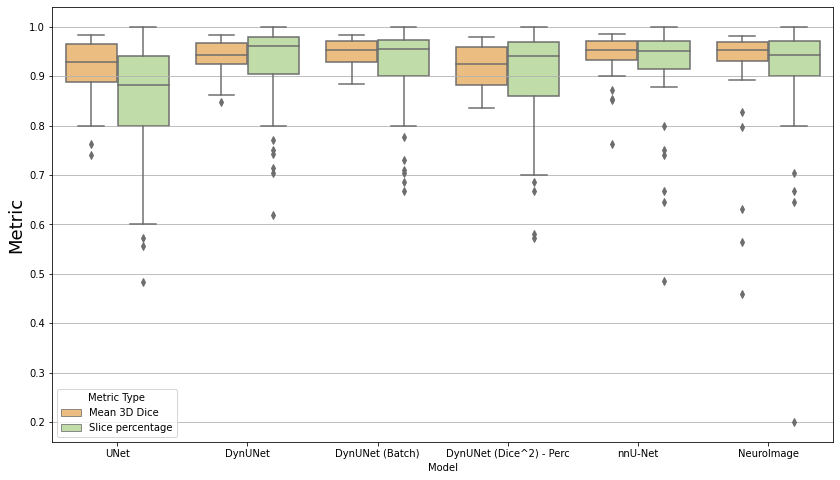

In [9]:
# create dataframe and plots
pd1 = pd.DataFrame(data={'Metric Type': "Mean 3D Dice", 'Group': full_list_mean_dice['Group'], 'Metric': full_list_mean_dice['MONAI_inplanecrop'], 'Model': 'UNet'})
pd1 = pd1.append(pd.DataFrame(data={'Metric Type': "Mean 3D Dice", 'Group': full_list_mean_dice['Group'], 'Metric': full_list_mean_dice['MONAI_dynUnet'], 'Model': 'DynUNet'}))
pd1 = pd1.append(pd.DataFrame(data={'Metric Type': "Mean 3D Dice", 'Group': full_list_mean_dice['Group'], 'Metric': full_list_mean_dice['MONAI_dynUnet_batch'], 'Model': 'DynUNet (Batch)'}))
pd1 = pd1.append(pd.DataFrame(data={'Metric Type': "Mean 3D Dice", 'Group': full_list_mean_dice['Group'], 'Metric': full_list_mean_dice['MONAI_dynUnet_val_perc'], 'Model': 'DynUNet (Dice^2) - Perc'}))
pd1 = pd1.append(pd.DataFrame(data={'Metric Type': "Mean 3D Dice", 'Group': full_list_mean_dice['Group'], 'Metric': full_list_mean_dice['nnUNet_uniform'], 'Model': 'nnU-Net'}))
pd1 = pd1.append(pd.DataFrame(data={'Metric Type': "Mean 3D Dice", 'Group': full_list_mean_dice['Group'], 'Metric': full_list_mean_dice['NeuroImage'], 'Model': 'NeuroImage'}))
pd1 = pd1.append(pd.DataFrame(data={'Metric Type': "Slice percentage", 'Group': full_list_percentage_slice['Group'], 'Metric': full_list_percentage_slice['MONAI_inplanecrop'], 'Model': 'UNet'}))
pd1 = pd1.append(pd.DataFrame(data={'Metric Type': "Slice percentage", 'Group': full_list_percentage_slice['Group'], 'Metric': full_list_percentage_slice['MONAI_dynUnet'], 'Model': 'DynUNet'}))
pd1 = pd1.append(pd.DataFrame(data={'Metric Type': "Slice percentage", 'Group': full_list_percentage_slice['Group'], 'Metric': full_list_percentage_slice['MONAI_dynUnet_batch'], 'Model': 'DynUNet (Batch)'}))
pd1 = pd1.append(pd.DataFrame(data={'Metric Type': "Slice percentage", 'Group': full_list_percentage_slice['Group'], 'Metric': full_list_percentage_slice['MONAI_dynUnet_val_perc'], 'Model': 'DynUNet (Dice^2) - Perc'}))
pd1 = pd1.append(pd.DataFrame(data={'Metric Type': "Slice percentage", 'Group': full_list_percentage_slice['Group'], 'Metric': full_list_percentage_slice['nnUNet_uniform'], 'Model': 'nnU-Net'}))
pd1 = pd1.append(pd.DataFrame(data={'Metric Type': "Slice percentage", 'Group': full_list_percentage_slice['Group'], 'Metric': full_list_percentage_slice['NeuroImage'], 'Model': 'NeuroImage'}))

fig = plt.figure(figsize=(14, 8))
b1 = sns.boxplot(x='Model', y='Metric', hue='Metric Type', data=pd1, palette="Spectral")
b1.set_ylabel('Metric', fontsize=18)
# b1.set_ylim([0, 1])
plt.grid(b=True,axis='y')

In [10]:
thr = 0.8
all_percentage = np.array(full_list_percentage_slice['MONAI_dynUnet_val_perc'])
idx = np.squeeze(np.argwhere(all_percentage < thr), axis=-1)
print(len(idx)/len(all_percentage)) 
# THERE IS SOMETHING FUNKY, THIS IS SUPPOSED TO BE 0.08!

0.18
